# Main Role of ChemBERTa
In this code, ChemBERTa is used as a pre-trained feature extractor. It takes the SMILES strings (a textual representation of chemical structures) of the molecules as input and converts them into numerical vectors, known as embeddings. These embeddings capture complex chemical information and structural properties of the molecules. Instead of using handcrafted molecular descriptors or fingerprints, ChemBERTa provides a high-dimensional, learned representation that can be used as input for subsequent machine learning models like XGBoost or Gradient Boosting classifiers.

In [ ]:
!git clone https://github.com/Mehran811/QSAR_Anti_CETP.git

Cloning into 'QSAR_Anti_CETP'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 3.19 MiB | 6.32 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
! pip install pandas
! pip install numpy
! pip install seaborn
! pip install matplotlib
! pip install rdkit
! pip install datamol
! pip install sklearn
! pip install scikit-fingerprints
! pip install shap
! pip install xgboost
! pip install -q transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.4/495.4 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 7.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.6/391.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors, rdMolDescriptors
from IPython.display import display
import datamol as dm
from skfp.fingerprints import MordredFingerprint, PubChemFingerprint, RDKitFingerprint, ECFPFingerprint, MACCSFingerprint, RDKit2DDescriptorsFingerprint, MAPFingerprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef, f1_score, confusion_matrix, accuracy_score, recall_score, precision_score, balanced_accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import cross_validate , RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import shap

from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
df_selected = pd.read_csv("/content/QSAR_Anti_CETP/Dataset with selected features.csv")
df_selected

,Name,Smiles,activity,dataset,ecfpfingerprint1019,ecfpfingerprint1050,ecfpfingerprint1084,ecfpfingerprint1309,ecfpfingerprint1487,ecfpfingerprint1765,...,rdkit_PEOE_VSA8,rdkit_PEOE_VSA9,rdkit_SMR_VSA1,rdkit_SMR_VSA3,rdkit_SMR_VSA6,rdkit_SlogP_VSA4,rdkit_VSA_EState2,rdkit_VSA_EState5,rdkit_VSA_EState7,rdkit_VSA_EState8
0,CHEMBL604308,O=C(COc1ccc(C(F)(F)F)cc1)Nc1ccc(-c2nc3cc(Cl)cc...,0.0,train,0,0,0,0,0,0,...,16.273472,5.563451,27.119797,4.983979,11.923671,0.000000,16.446600,0.124531,-4.423603,-0.348210
1,CHEMBL341275,COC(=O)c1cccc(CN(CC(O)C(F)(F)F)c2cccc(Oc3ccccc...,0.0,train,0,0,0,0,0,0,...,18.298510,19.218006,32.546036,0.000000,18.554464,0.000000,13.189133,0.465556,-7.324485,-0.673108
2,CHEMBL259005,Cc1cc(C)c2oc(-c3ccc(NC(=O)COc4cccc(C#N)c4)cc3)...,0.0,train,0,0,0,0,0,0,...,11.250837,11.632673,13.948551,4.983979,11.923671,25.178587,16.725416,0.718885,0.000000,3.879136
3,CHEMBL2032421,CC(C)OC(=O)N1c2ccc(C(F)(F)F)cc2[C@@H](N(Cc2cc(...,1.0,train,1,0,0,1,0,0,...,12.586597,41.571220,49.045135,20.207254,9.799819,5.917906,16.826496,-0.324725,-15.090106,2.554816
4,CHEMBL4864315,COc1ncc(-c2ccc(C(=O)O)cc2C)cc1-c1cc(C(F)(F)F)c...,1.0,train,1,0,1,1,1,1,...,22.887197,49.190475,68.419930,14.867866,14.219595,6.923737,33.796486,-2.287084,-16.917070,2.216469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,AMPHETAMINE ASPARTATE/DEXTROAMPHETAMINE SULFATE,CC(N)Cc1ccccc1.C[C@H](N)Cc1ccccc1.C[C@H](N)Cc1...,NaN,FDA,0,0,0,0,0,0,...,18.125523,6.420822,37.325424,0.000000,0.000000,0.000000,19.617268,-2.497870,2.386759,6.062500
4038,PACRITINIB CITRATE,C1=C/COCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc...,NaN,FDA,0,0,0,0,0,0,...,29.555890,44.963100,49.020310,14.867866,44.771700,0.000000,42.098755,-3.624703,6.044494,5.988914
4039,FINGOLIMOD LAURYL SULFATE,CCCCCCCCCCCCOS(=O)(=O)O.CCCCCCCCc1ccc(CCC(N)(C...,NaN,FDA,0,0,0,0,0,0,...,0.000000,25.359571,27.366688,0.000000,19.820646,0.000000,0.000000,0.000000,22.361940,4.195031
4040,VENLAFAXINE BESYLATE,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1.O=S(=O)(O)c1c...,NaN,FDA,0,0,0,0,0,0,...,12.462663,17.606333,22.813938,4.899909,27.749897,0.000000,2.094055,1.038605,5.349052,0.877806


In [ ]:
# 📦 Imports
import pandas as pd

# 📥 Load dataset
df_selected = pd.read_csv("/content/QSAR_Anti_CETP/Dataset with selected features.csv")

# 🔍 1. Identify columns (excluding 'activity') with any NaNs
cols_with_nan = df_selected.drop(columns=['activity']).isnull().any()
columns_containing_nan = cols_with_nan[cols_with_nan].index.tolist()

if columns_containing_nan:
    print("Columns containing NaN values (excluding 'activity'):")
    print(columns_containing_nan)
    print("\nNaN counts per column:")
    print(df_selected[columns_containing_nan].isnull().sum())
else:
    print("✅ No NaNs found in selected features (excluding 'activity').")

# 🧹 2. Drop rows with NaNs in critical feature (based on earlier experience)
df_selected_cleaned = df_selected.dropna(subset=['rdkit_MinPartialCharge']).copy()

# ✅ Confirm NaN removal worked
print("\nRemaining NaNs in 'rdkit_MinPartialCharge':")
print(df_selected_cleaned['rdkit_MinPartialCharge'].isnull().sum())

# 🔄 Optional: check again for any NaNs anywhere
print("\n🧼 Final NaN check across all columns:")
print(df_selected_cleaned.isnull().sum().sort_values(ascending=False).head(5))

# ✅ 3. Split based on pre-labeled dataset column
train_df = df_selected_cleaned[df_selected_cleaned['dataset'] == 'train'].copy()
val_df   = df_selected_cleaned[df_selected_cleaned['dataset'] == 'test'].copy()
fda_df   = df_selected_cleaned[df_selected_cleaned['dataset'] == 'FDA'].copy()

# Final NaN safety check before saving
assert train_df.isnull().sum().sum() == 0, "Train set still has NaNs!"
assert val_df.isnull().sum().sum() == 0, "Validation set still has NaNs!"

# 💾 4. Save each set to separate CSVs
train_df.to_csv('/content/qsar_train_cleaned.csv', index=False)
val_df.to_csv('/content/qsar_validation_cleaned.csv', index=False)
fda_df.to_csv('/content/qsar_fda_cleaned.csv', index=False)

print("\n✅ All cleaned and split datasets saved:")
print("- /content/qsar_train_cleaned.csv")
print("- /content/qsar_validation_cleaned.csv")
print("- /content/qsar_fda_cleaned.csv")


Columns containing NaN values (excluding 'activity'):
['rdkit_MinPartialCharge']

NaN counts per column:
rdkit_MinPartialCharge    11
dtype: int64

Remaining NaNs in 'rdkit_MinPartialCharge':
0

🧼 Final NaN check across all columns:
activity               2620
Name                      0
Smiles                    0
dataset                   0
ecfpfingerprint1019       0
dtype: int64

✅ All cleaned and split datasets saved:
- /content/qsar_train_cleaned.csv
- /content/qsar_validation_cleaned.csv
- /content/qsar_fda_cleaned.csv


# Training the models

In [ ]:
!pip install -q transformers
from transformers import AutoTokenizer, AutoModel

In summary, model.eval() and the torch.no_grad() are used together to ensure that ChemBERTa is used solely for generating stable and consistent embeddings without any further training or the variable behavior of training-specific layers.

In [ ]:
# Load pre-trained ChemBERTa from HuggingFace
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model.eval()  # freeze the model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(767, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [ ]:
# Define a function to embed SMILES strings

def smiles_to_embedding(smiles_list, tokenizer, model, device='cpu', batch_size=32):
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(smiles_list), batch_size)):
            batch = smiles_list[i:i+batch_size]
            encoded = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=128)
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = output.last_hidden_state  # (batch, seq_len, hidden_dim)
            pooled = last_hidden_state[:, 0, :]  # CLS token embedding
            embeddings.append(pooled.cpu().numpy())

    return np.concatenate(embeddings, axis=0)


In [ ]:
# Load your training and validation sets

train_df = pd.read_csv('/content/qsar_train_cleaned.csv')
val_df = pd.read_csv('/content/qsar_validation_cleaned.csv')

# Extract SMILES and labels
train_smiles = train_df['Smiles'].tolist()
val_smiles = val_df['Smiles'].tolist()

y_train = train_df['activity'].values
y_val = val_df['activity'].values


In [ ]:
# Generate embeddings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# This might take ~2–5 minutes depending on dataset size
X_train_emb = smiles_to_embedding(train_smiles, tokenizer, model, device=device)
X_val_emb   = smiles_to_embedding(val_smiles, tokenizer, model, device=device)

# Save to disk
np.save('/content/X_train_chemberta.npy', X_train_emb)
np.save('/content/X_val_chemberta.npy', X_val_emb)
np.save('/content/y_train.npy', y_train)
np.save('/content/y_val.npy', y_val)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]


100%|██████████| 9/9 [00:00<00:00, 13.39it/s]


In [ ]:
# Load
X_train_emb = np.load('/content/X_train_chemberta.npy')
X_val_emb   = np.load('/content/X_val_chemberta.npy')
y_train     = np.load('/content/y_train.npy')
y_val       = np.load('/content/y_val.npy')


In [ ]:
#  Train XGBoost classifier
clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

clf.fit(X_train_emb, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:58:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Evaluate model
y_pred = clf.predict(X_val_emb)
y_proba = clf.predict_proba(X_val_emb)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))
print("MCC:", matthews_corrcoef(y_val, y_pred))


Accuracy: 0.833922261484099
F1 Score: 0.7344632768361582
ROC-AUC: 0.8783068783068784
MCC: 0.6168365498705752


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef

# Define model with best-found parameters
gb_model = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

# Train
gb_model.fit(X_train_emb, y_train)

# Predict
y_pred = gb_model.predict(X_val_emb)
y_proba = gb_model.predict_proba(X_val_emb)[:, 1]

# Evaluate
print("✅ Evaluation on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))
print("MCC:", matthews_corrcoef(y_val, y_pred))


✅ Evaluation on Validation Set:
Accuracy: 0.8091872791519434
F1 Score: 0.6966292134831461
ROC-AUC: 0.8838793200495328
MCC: 0.5599719890174313


# FDA

In [ ]:
# === Cell 1: Embed FDA SMILES with ChemBERTa ===

import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Load cleaned FDA dataset
fda_df = pd.read_csv('/content/qsar_fda_cleaned.csv')

# Load ChemBERTa tokenizer and model (frozen)
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chemberta = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chemberta.eval()

# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
chemberta.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(767, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [ ]:
# Extract SMILES and compute embeddings
fda_smiles = fda_df['Smiles'].tolist()
X_fda = smiles_to_embedding(fda_smiles, tokenizer, chemberta, device=device)

# Save to reuse later if needed
np.save('/content/X_fda_chemberta.npy', X_fda)

100%|██████████| 82/82 [00:06<00:00, 13.10it/s]



✅ Saved full results to: fda_predictions_chemberta_full.csv

🧪 FDA Predictions Summary
Total drugs: 2620
Predicted Active: 29
Predicted Inactive: 2591

Highly confident actives (>80%): 2

🔝 Top 10 Most Active Drugs by Probability:
                         Name  probability_active
939                APREPITANT            0.964285
2612             MOBOCERTINIB            0.874540
1298            FOSAPREPITANT            0.799397
2592            CANAGLIFLOZIN            0.797559
2364  TENAPANOR HYDROCHLORIDE            0.794828
2560        MITAPIVAT SULFATE            0.792903
1970               LETERMOVIR            0.785012
555              ITRACONAZOLE            0.754834
1500     OLMESARTAN MEDOXOMIL            0.744123
1210        METOCURINE IODIDE            0.740714


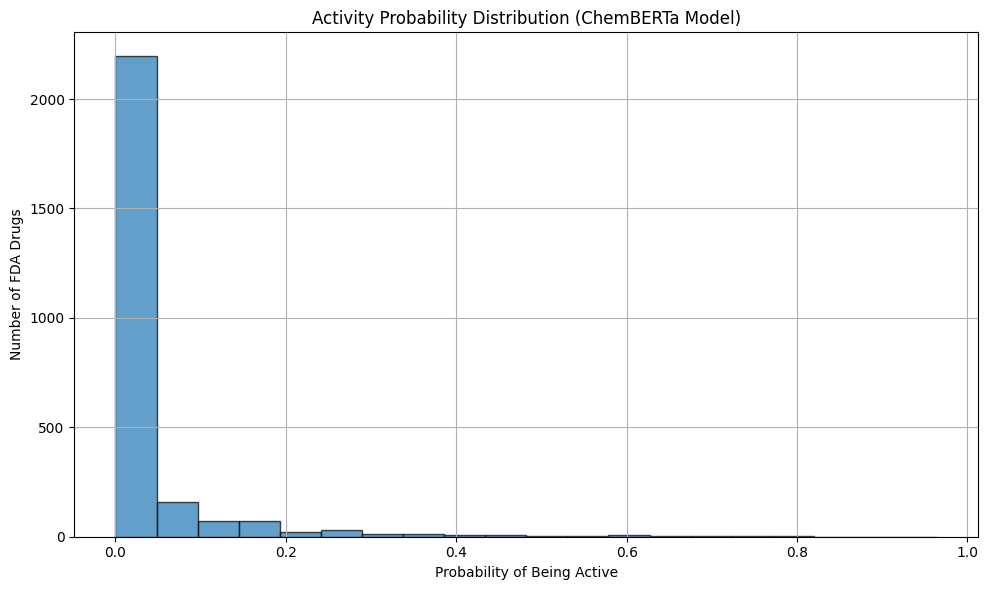

Confidence > 50%: 29 actives, 2591 inactives
Confidence > 60%: 20 actives, 2578 inactives
Confidence > 70%: 11 actives, 2551 inactives
Confidence > 80%: 2 actives, 2503 inactives
Confidence > 90%: 1 actives, 2356 inactives

Uncertain predictions (40–60%): 22


In [ ]:
# === Cell 2: Predict FDA drug activity, analyze, and save full results ===

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load FDA embeddings
X_fda = np.load('/content/X_fda_chemberta.npy')

# Load metadata and original features
fda_df = pd.read_csv('/content/qsar_fda_cleaned.csv')

# Load trained Gradient Boosting model
# model = joblib.load('/content/gb_chemberta_model.pkl')


# Predict class labels and class probabilities
model = clf
y_pred = model.predict(X_fda)
y_proba = model.predict_proba(X_fda)

# Add prediction results to full FDA dataframe
fda_df['predicted_activity'] = y_pred
fda_df['probability_inactive'] = y_proba[:, 0]
fda_df['probability_active'] = y_proba[:, 1]

# Save complete FDA predictions (with features and SMILES)
fda_df.to_csv('/content/fda_predictions_chemberta_full.csv', index=False)
print("\n✅ Saved full results to: fda_predictions_chemberta_full.csv")

# Summary
print(f"\n🧪 FDA Predictions Summary")
print(f"Total drugs: {len(fda_df)}")
print(f"Predicted Active: {sum(y_pred)}")
print(f"Predicted Inactive: {len(y_pred) - sum(y_pred)}")

# High-confidence active compounds
high_confidence = fda_df[(fda_df['predicted_activity'] == 1) & (fda_df['probability_active'] > 0.8)]
print(f"\nHighly confident actives (>80%): {len(high_confidence)}")

# Top 10 most likely active drugs
top_10 = fda_df.sort_values('probability_active', ascending=False).head(10)
print("\n🔝 Top 10 Most Active Drugs by Probability:")
print(top_10[['Name', 'probability_active']])

# Plot distribution of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(fda_df['probability_active'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Probability of Being Active')
plt.ylabel('Number of FDA Drugs')
plt.title('Activity Probability Distribution (ChemBERTa Model)')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/fda_probability_distribution.png', dpi=300)
plt.show()

# Confidence-level breakdown
for c in [0.5, 0.6, 0.7, 0.8, 0.9]:
    a = len(fda_df[(fda_df['predicted_activity'] == 1) & (fda_df['probability_active'] > c)])
    i = len(fda_df[(fda_df['predicted_activity'] == 0) & (fda_df['probability_inactive'] > c)])
    print(f"Confidence > {int(c*100)}%: {a} actives, {i} inactives")

# Uncertain predictions (40–60% range)
uncertain = fda_df[(fda_df['probability_active'] > 0.4) & (fda_df['probability_active'] < 0.6)]
print(f"\nUncertain predictions (40–60%): {len(uncertain)}")


# Similarity Check

In [ ]:
# ------------------- SIMILARITY ANALYSIS BETWEEN FDA AND TRAIN ACTIVES -------------------

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import pandas as pd
from tqdm import tqdm

# Load your original training dataset and FDA predictions
df_train = pd.read_csv("Dataset with selected features.csv")  # Make sure this path matches your actual one
df_fda = pd.read_csv("fda_predictions_chemberta_full.csv")

# Filter only compounds with activity == 1 in train and predicted_activity == 1 in FDA
train_actives = df_train[df_train['activity'] == 1].copy()
fda_actives = df_fda[df_fda['predicted_activity'] == 1].copy()

# Convert SMILES to RDKit Mol objects and compute ECFP4 fingerprints (radius=2)
def get_ecfp4_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

train_actives['fp'] = train_actives['Smiles'].apply(get_ecfp4_fingerprint)
fda_actives['fp'] = fda_actives['Smiles'].apply(get_ecfp4_fingerprint)

# Remove rows with invalid fingerprints
train_actives = train_actives[train_actives['fp'].notna()]
fda_actives = fda_actives[fda_actives['fp'].notna()]

# Compute Tanimoto similarity between every FDA active and every train active
similarities = []

print("Calculating Tanimoto similarity between FDA actives and train actives...")

for i, fda_row in tqdm(fda_actives.iterrows(), total=len(fda_actives)):
    for j, train_row in train_actives.iterrows():
        sim = DataStructs.TanimotoSimilarity(fda_row['fp'], train_row['fp'])
        similarities.append({
            'FDA_Name': fda_row['Name'],
            'FDA_SMILES': fda_row['Smiles'],
            'Train_Name': train_row['Name'],
            'Train_SMILES': train_row['Smiles'],
            'Similarity': sim
        })

# Create a DataFrame from similarity results
similarity_df = pd.DataFrame(similarities)

# Optional: Save to CSV
similarity_df.to_csv("FDA_vs_Train_similarity.csv", index=False)

# Show top 10 most similar pairs
similarity_df.sort_values(by='Similarity', ascending=False).head(10)


[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerator
[10:38:37] DEPRECATION WARNING: please use MorganGenerat

Calculating Tanimoto similarity between FDA actives and train actives...


100%|██████████| 29/29 [00:01<00:00, 28.00it/s]


,FDA_Name,FDA_SMILES,Train_Name,Train_SMILES,Similarity
2671,APREPITANT,C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...,CHEMBL1934996,COc1cc(F)c(C(C)C)cc1-c1ccc(F)cc1CN1C(=O)O[C@H]...,0.297872
12715,BEROTRALSTAT,N#Cc1cccc(C(NCC2CC2)c2ccc(F)c(NC(=O)c3cc(C(F)(...,CHEMBL1684852,CC(C)c1cc(C#N)cc2nc(-c3ccc(C(=O)NCC4CCN(c5cccc...,0.289474
12865,BEROTRALSTAT,N#Cc1cccc(C(NCC2CC2)c2ccc(F)c(NC(=O)c3cc(C(F)(...,CHEMBL2165707,N#Cc1ccc([C@@](Cc2ccccc2)(NC(=O)NC2CCCC2)c2cc(...,0.283019
2668,APREPITANT,C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...,CHEMBL1935013,COc1cc(F)c(C(C)C)cc1-c1ccc(C2CC2)cc1CN1C(=O)O[...,0.282828
2623,APREPITANT,C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...,CHEMBL1935004,COc1cc(F)c(C(C)C)cc1-c1ccc(C(C)C)cc1CN1C(=O)O[...,0.281250
2812,APREPITANT,C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...,CHEMBL1800622,COc1ccc(C(C)C)cc1-c1ccc(C(F)(F)F)cc1CN1C(=O)O[...,0.279570
6388,LETERMOVIR,COc1cccc(N2CCN(C3=Nc4c(F)cccc4[C@H](CC(=O)O)N3...,CHEMBL3933320,COc1ccc([C@H]2C[C@H](C(=O)O)C2)cc1-c1ccc(C(F)(...,0.278846
2804,APREPITANT,C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...,CHEMBL1800801,COc1ccc(C(C)C)cc1-c1ccc(C(F)(F)F)cc1CN1C[C@@H]...,0.276596
6309,LETERMOVIR,COc1cccc(N2CCN(C3=Nc4c(F)cccc4[C@H](CC(=O)O)N3...,CHEMBL1641618,COc1cccc(N2CCN(CC(=O)Nc3ccc(-c4nc5cc(C#N)cc(C)...,0.276190
2515,APREPITANT,C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...,CHEMBL4852781,COc1cc(F)c(C(C)C)cc1-c1ccc(C(F)(F)F)cc1CN1C(=O...,0.275510
